Use as ref all words from the Linux American dictionary with 5 words (uppercase)

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import wordle

In [91]:
# we need unidecode to fix accents in certain words

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 7, 6
rcParams['figure.dpi'] = 60

import warnings
warnings.filterwarnings("ignore")


### Load words from dictionaries to be tested

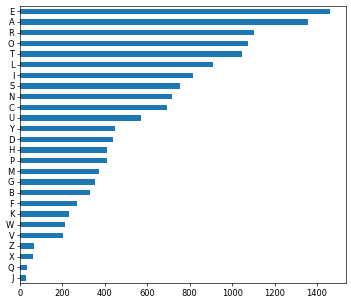

In [92]:
words_by_dictionary, df_by_dictionary = wordle.load_dictionaries()

### Main simulation function that gets parallelized

In [93]:

def run_query(qi, query, df_bkp, plot=False, log=False):
    # avoid printing warnings during parallel running
    import warnings; warnings.filterwarnings("ignore")
    
    day_i, dictionary_name, challenge_word, strategy = query
    
    if log:
        print(day_i, dictionary_name, challenge_word, strategy)
    select_by, sort_ascending = strategy
    guess_i = 0
    remaining_words = list(df_bkp['word'])
    
    assert challenge_word in remaining_words
    n_letters = len(remaining_words[0])
    
    last_guesses = set()
    
    while guess_i < 7:
        guess_i += 1    

        best_guess = wordle.infer(remaining_words, strategy[0], last_guesses=last_guesses)
        
        last_guesses.add(best_guess)
        remaining_words_by_guess = wordle.get_guesses(remaining_words, challenge_word, [best_guess])
        assert challenge_word in remaining_words

        if log:
            print('\n\nGUESS # %i' % guess_i, best_guess, end=' ')
        
        remaining_words = remaining_words_by_guess[best_guess]
        
            ## the word has been guessed. Stop.
        if len(remaining_words) <= 1:
            if len(remaining_words) == 1:
                guess_i += 1
            break
        if log:
            print('left', len(remaining_words))
        
        wordle.plot_words(remaining_words)

    final_scores = [day_i, select_by, sort_ascending, dictionary_name, challenge_word, guess_i]
    # print(final_scores)
    
    return_dict[qi] = final_scores
    
    if log:
        print('day %i done...\n\n' % day_i)
        print('total guesses', guess_i)

### Simulate a challenge
#### Prepare queries for main function

In [94]:
import random
random.seed(500)

# strategy name, sorting type
strategies = [['wordfreq', False],
              ['posfreq', False],
              ['posfreqcovar', False]]

n_days = 500 # None # len()


all_words = []
for k in words_by_dictionary:
    words = words_by_dictionary[k]    
    if n_days is not None:
        if n_days <= len(words):
            words = random.sample(words, n_days)
    all_words += [[k, w] for w in words]    

queries = [[day_i, q[0], q[1], st] for day_i, q in enumerate(all_words) for st in strategies]
print(n_days, len(words), len(queries))

next_args = [[qi, q, df_by_dictionary[q[1]]] for qi, q in enumerate(queries)]
len(next_args)
# next_args[10][:2]

500 500 9000


9000

In [95]:
import multiprocessing
manager = multiprocessing.Manager()
return_dict = manager.dict()

### Debug one case, to examine intermediat viz

In [96]:
for q in next_args:
    if q[1][2] == 'SOLAR':
        print(q)
        
# next_args = [q for q in next_args if q[1][2] == 'SOLAR']

[6273, [2091, 'wordle_5', 'SOLAR', ['wordfreq', False]],       0  1  2  3  4  score   word
0     W  R  I  S  T   3163  WRIST
1     B  R  E  E  D   2806  BREED
2     W  R  Y  L  Y   2238  WRYLY
3     B  A  C  O  N   3066  BACON
4     B  R  O  O  K   2144  BROOK
...  .. .. .. .. ..    ...    ...
2310  S  L  O  T  H   3260  SLOTH
2311  E  S  S  A  Y   3306  ESSAY
2312  S  T  I  C  K   2756  STICK
2313  S  Q  U  A  D   2537  SQUAD
2314  T  A  B  O  O   2743  TABOO

[2315 rows x 7 columns]]
[6274, [2091, 'wordle_5', 'SOLAR', ['posfreq', False]],       0  1  2  3  4  score   word
0     W  R  I  S  T   3163  WRIST
1     B  R  E  E  D   2806  BREED
2     W  R  Y  L  Y   2238  WRYLY
3     B  A  C  O  N   3066  BACON
4     B  R  O  O  K   2144  BROOK
...  .. .. .. .. ..    ...    ...
2310  S  L  O  T  H   3260  SLOTH
2311  E  S  S  A  Y   3306  ESSAY
2312  S  T  I  C  K   2756  STICK
2313  S  Q  U  A  D   2537  SQUAD
2314  T  A  B  O  O   2743  TABOO

[2315 rows x 7 columns]]
[6275, [2091, 'word

In [97]:
idx = 1
print('')
# print(next_args[idx])
print('')
run_query(next_args[idx][0], next_args[idx][1], next_args[idx][2], plot=True, log=True)



0 wordle_3 INE ['posfreq', False]


GUESS # 1 RIE left 15


GUESS # 2 IPE left 14


GUESS # 3 IGE left 13


GUESS # 4 IDE left 12


GUESS # 5 IXE left 11


GUESS # 6 IFE left 10


GUESS # 7 IKE left 9
day 0 done...


total guesses 7


#### Define the number of cores to be used (e.g. 2, based on device)

In [100]:
n_cores = 5

In [101]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
wordle.ThreadingUtils.run(run_query, next_args, n_cores=n_cores, input_list_kwargs=[{} for args in next_args])

run function <function run_query at 0x7f9cdd996050> with n_cores = 5
<function run_query at 0x7f9cdd996050>
# Total groups 1801
Current group 0 (start/end) 0 5
Current group 10 (start/end) 50 55
Current group 20 (start/end) 100 105
Current group 30 (start/end) 150 155
Current group 40 (start/end) 200 205
Current group 50 (start/end) 250 255
Current group 60 (start/end) 300 305
Current group 70 (start/end) 350 355
Current group 80 (start/end) 400 405
Current group 90 (start/end) 450 455
Current group 100 (start/end) 500 505
Current group 110 (start/end) 550 555
Current group 120 (start/end) 600 605
Current group 130 (start/end) 650 655
Current group 140 (start/end) 700 705
Current group 150 (start/end) 750 755
Current group 160 (start/end) 800 805
Current group 170 (start/end) 850 855
Current group 180 (start/end) 900 905
Current group 190 (start/end) 950 955
Current group 200 (start/end) 1000 1005
Current group 210 (start/end) 1050 1055
Current group 220 (start/end) 1100 1105
Current g

### Visualize results

In [102]:
final_scores = []
for k in return_dict.keys():
    # print(k)
    # print(k, return_dict[k])
    next_scores = return_dict[k]
    
    final_scores.append(next_scores)
    if len(final_scores) == len(next_args):
        break

res = pd.DataFrame(final_scores, columns=['day.i', 'strategy', 'sort.ascending', 'dictionary.name', 'word', 'n.guesses'])
res['k'] = res['dictionary.name'] + ':' + res['word']
# matrix format
m = res.pivot('k', 'strategy', 'n.guesses')
res.sort_values('n.guesses', ascending=False).head()


,day.i,strategy,sort.ascending,dictionary.name,word,n.guesses,k
2632,877,posfreqcovar,False,american_3,OLO,8,american_3:OLO
2095,699,wordfreq,False,american_3,ASE,8,american_3:ASE
2898,966,posfreq,False,american_3,OOK,8,american_3:OOK
2899,965,posfreqcovar,False,american_3,UIP,8,american_3:UIP
5768,1922,posfreqcovar,False,american_4,ALOR,8,american_4:ALOR


#### Visualizing number of guesses by strategy

In [103]:
# best covariation
m['diff'] = m['posfreqcovar'] - m['posfreq']
m.sort_values('diff', ascending=False).head()

strategy,posfreq,posfreqcovar,wordfreq,diff
k,,,,
american_3:EIR,2,8,7,6
wordle_3:EIR,2,8,7,6
wordle_4:ALOR,3,8,3,5
american_3:AOR,3,8,6,5
american_4:ALOR,3,8,3,5


In [104]:
# worst covariation
m.sort_values('diff', ascending=False).tail()

strategy,posfreq,posfreqcovar,wordfreq,diff
k,,,,
wordle_4:YLAW,8,4,8,-4
wordle_4:ENET,7,3,3,-4
american_4:YLAW,8,4,8,-4
american_3:EGY,8,3,7,-5
american_3:TIA,8,3,7,-5


In [105]:
res.groupby(['dictionary.name', 'strategy']).mean()[['n.guesses']] # .sort_values('n.guesses')

n.guesses
dictionary.name strategy               
american_3      posfreq           6.562
                posfreqcovar      6.646
                wordfreq          6.582
american_4      posfreq           5.276
                posfreqcovar      5.458
                wordfreq          5.262
american_5      posfreq           4.050
                posfreqcovar      4.182
                wordfreq          4.042
wordle_3        posfreq           6.530
                posfreqcovar      6.628
                wordfreq          6.544
wordle_4        posfreq           5.268
                posfreqcovar      5.490
                wordfreq          5.334
wordle_5        posfreq           4.070
                posfreqcovar      4.214
                wordfreq          4.036

In [106]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


Text(0, 0.5, '# guesses')

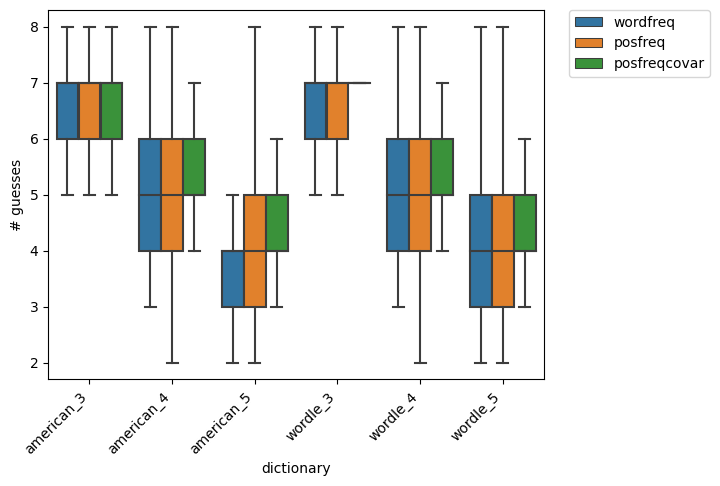

In [107]:
sns.boxplot(data=res, hue='strategy', y='n.guesses', x='dictionary.name', order=['american_3', 'american_4', 'american_5', 'wordle_3', 'wordle_4', 'wordle_5'],
            hue_order=['wordfreq', 'posfreq', 'posfreqcovar'], fliersize=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=45, ha='right')
plt.xlabel('dictionary')
plt.ylabel('# guesses')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


posfreq 5.292666666666666
posfreqcovar 5.436333333333334
wordfreq 5.3


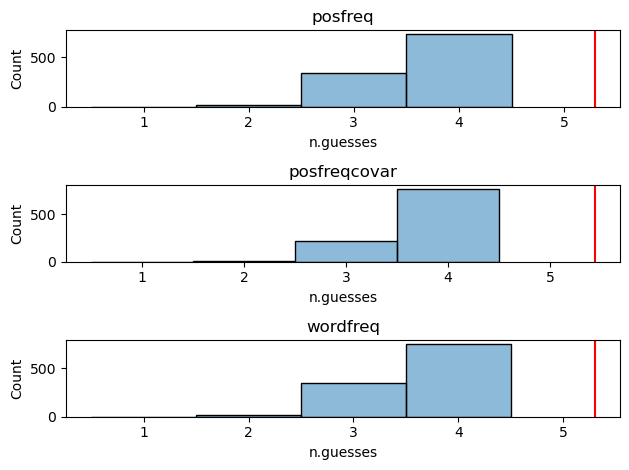

In [126]:
i = 1
for st, grp in res.groupby('strategy'):
    ax = plt.subplot(3, 1, i)
    sns.histplot(grp, x='n.guesses', hue='strategy', ax=ax, bins=np.arange(0,5)+0.5) #  multiple='stack') # bins=4)
    i += 1
    plt.title(st)
    ax.legend().set_visible(False)
    
    mean = np.mean(grp['n.guesses'])
    print(st, mean)
    plt.axvline(mean, c='red')
    ax.locator_params(axis='y', integer=True)

    
plt.tight_layout()
plt.show()


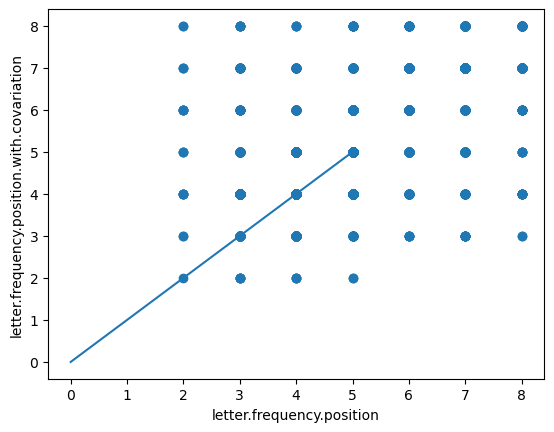

In [109]:
plt.scatter(m['posfreq'], m['posfreqcovar'])
plt.xlabel('letter.frequency.position')
plt.ylabel('letter.frequency.position.with.covariation')
plt.plot([0, 5], [0, 5])